# Full Trajectory Estimation

In [42]:
import os
import pickle
import math
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
from scipy import spatial
import pandas as pd
from glob import glob
from time import time
from scipy.stats import linregress
from pyomo.environ import *
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from lib import misc, utils, app
from lib.calib import triangulate_points_fisheye, project_points_fisheye
from pyntcloud import PyntCloud

#plt.style.use(os.path.join('..', 'configs', 'mplstyle.yaml'))

%load_ext autoreload
%autoreload 2

ROOT_DATA_DIR = os.path.join("/Users/user/Documents/desktop_cleanup/", "walk")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
pc = PyntCloud.from_file('/Users/user/Desktop/5m/pcd/1.pcd')
K = [[16000, 0, 0], [0, 16000, 0], [1000, 500, 0]]
d = [0, 0, 0, 0, 0]
r = [[1, 0, 0], [0, 0, -1], [0, 1, 0]]
t = [[0],[1],[0]]


In [47]:
# Conversion functions for rgbd -> xyz -> uv coordinate transforms

def rgbd_to_xyz(u, v, d, K):
    """
    Converts given pixel and depth coordinates to xyz in world frame
    """
    x = u - K[0][2] + 0.5
    y = v - K[1][2] + 0.5

    x_df = d / K[0][0]
    y_df = d / K[1][1]
    x *= x_df
    y *= y_df

    return [x, d, y]

def xyz_to_uv(x, y, z, K):
    x_df = y / K[0][0]
    y_df = y / K[1][1]

    x /= x_df
    z /= y_df
    u = x + K[0][2] - 0.5
    v = z + K[1][2] - 0.5

    return [u,v]


Build depth vector from pcd files

In [48]:
K = [[16000, 0, 0], [0, -16000, 0], [1000, 500, 0]]
d = [0, 0, 0, 0, 0]
r = [[1, 0, 0], [0, 0, -1], [0, 1, 0]]
t = [[0],[1],[0]]

uv_points_arr = []
pcd_points_arr = []

pcd_folder = "/Users/user/Desktop/5m/pcd"

pcd_paths = [os.path.join(pcd_folder, fname) for fname in os.listdir(pcd_folder) if "pcd" in fname]

for pcd_path in pcd_paths:

    pc = PyntCloud.from_file(pcd_path)
    pcd_points = []
    uv_points = []

    for i in range(len(pc.points)):
        if(pc.points["intensity"][i]>80):
            pt = [pc.points["y"][i], pc.points["x"][i], pc.points["z"][i], pc.points["intensity"][i]]
            uvpt = xyz_to_uv(pt[0], pt[1], pt[2], K)
            pcd_points.append(pt)
            uv_points.append(uvpt)

    uv_points_arr.append(np.asarray(uv_points))
    pcd_points_arr.append(np.asarray(pcd_points))

print(uv_points_arr[0])


[[352.89372679 803.56998471]
 [353.77294519 895.13381087]
 [355.63033415 835.11302452]
 ...
 [660.65701264 658.68337626]
 [673.55766217 592.74956475]
 [687.6932327  620.64860276]]


# Reconstruction params

In [49]:
DATA_DIR = ROOT_DATA_DIR
DLC_DIR = os.path.join(ROOT_DATA_DIR, "dlc")

start_frame = 13000
end_frame = 13100

# DLC p_cutoff - any points with likelihood < dlc_thresh are not trusted in optimisation
dlc_thresh = 0.5 # change this only if the optimisation result is unsatisfactory

Camera matrix obtained from the pcd_cam_calibrator tool

In [50]:
K = [[-20000, 0, 0], [0, -20000, 0], [426, 240, 0]]
d = [0, 0, 0, 0, 0]
r = [[1, 0, 0], [0, 0, -1], [0, 1, 0]]
t = [[0],[1],[0]]

Constructing estimate vectors for initialisation of the FTE

In [51]:
print("Loading data")

df_paths = sorted(glob(os.path.join(DLC_DIR, '*.h5')))
markers = misc.get_markers()

points_2d_df = utils.load_dlc_points_as_df(df_paths, verbose=False)
print(points_2d_df)

print(markers)

def get_meas_from_df(n, c, l, d):
    n_mask = points_2d_df["frame"]== n-1
    l_mask = points_2d_df["marker"]== markers[l-1]
    c_mask = points_2d_df["camera"]== c-1
    d_idx = {1:"x", 2:"y"}
    val = points_2d_df[n_mask & l_mask & c_mask]
    return val[d_idx[d]].values[0]

def get_likelihood_from_df(n, c, l):
    n_mask = points_2d_df["frame"]== n-1
    l_mask = points_2d_df["marker"]== markers[l-1]
    c_mask = points_2d_df["camera"]== c-1
    val = points_2d_df[n_mask & l_mask & c_mask]
    return val["likelihood"].values[0]

rang = end_frame - start_frame
noses = np.zeros((rang, 4))
pcd_index = 0

for frm in range(rang):
    current_frm = str(start_frame+frm)
    if ("/"+current_frm+".pcd" in os.listdir(pcd_folder)):
        x_c = get_meas_from_df(frm+1, 1, 5, 1)
        y_c = get_meas_from_df(frm+1, 1, 5, 2)
        pt_search = [x_c, y_c]
        search_index = spatial.KDTree(uv_points_arr[pcd_index]).query(pt)[1]
        closest_pt = uv_points_arr[pcd_index][search_index]
        closest_depth = pcd_points_arr[pcd_index][search_index][1]
        d_c = closest_depth
        noses[frm] = [frm]+rgbd_to_xyz(x_c, y_c, d_c, K)
        pcd_index+=1
    elif frm>0:
        noses[frm] = noses[frm-1]
    else:
        noses[frm]=0

x_slope, x_intercept, *_ = linregress(noses[:,0], noses[:,1])
y_slope, y_intercept, *_ = linregress(noses[:,0], noses[:,2])
z_slope, z_intercept, *_ = linregress(noses[:,0], noses[:,3])
frame_est = np.arange(end_frame)
x_est = frame_est*x_slope + x_intercept
y_est = frame_est*y_slope + y_intercept
z_est = frame_est*z_slope + z_intercept
psi_est = np.arctan2(y_slope, x_slope)

print(x_est)
print(y_est)
print(z_est)


Loading data
       frame camera         marker           x           y  likelihood
0          0      0   l_back_ankle   -0.400800  478.003174    0.000037
1          0      0    l_back_knee    0.868324  480.355011    0.000017
2          0      0     l_back_paw    1.664483  479.916992    0.000030
3          0      0          l_eye  862.771790  480.141022    0.000033
4          0      0  l_front_ankle   -1.210734  477.514557    0.000049
...      ...    ...            ...         ...         ...         ...
247695  9907      0     r_shoulder  216.048843  349.359406    0.813347
247696  9907      0          spine  161.158127  323.471436    0.992151
247697  9907      0          tail1   50.857265  389.144867    0.973239
247698  9907      0          tail2   21.269295  433.918396    0.708430
247699  9907      0      tail_base   71.436821  326.137573    0.985515

[247700 rows x 6 columns]
['nose', 'l_eye', 'r_eye', 'neck_base', 'spine', 'tail_base', 'tail1', 'tail2', 'r_shoulder', 'r_front_knee'

/opt/anaconda3/envs/acinoset/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/opt/anaconda3/envs/acinoset/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [27]:
print(noses[:,1])
print(y_est[:-1])
print(noses[:,3])

# Robust Cost Function

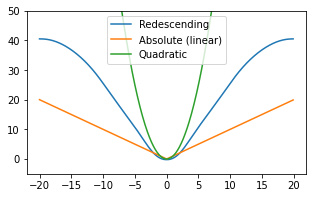

In [47]:
# PLOT OF REDESCENDING, ABSOLUTE AND QUADRATIC COST FUNCTIONS
# we use a redescending cost to stop outliers affecting the optimisation negatively
redesc_a = 3
redesc_b = 10
redesc_c = 20

#Plot
r_x = np.arange(-20,20, 1e-1)
r_y1 = [misc.redescending_loss(i, redesc_a, redesc_b, redesc_c) for i in r_x]
r_y2 = abs(r_x)
r_y3 = r_x**2
plt.figure(figsize=(5,3))
plt.plot(r_x,r_y1, label="Redescending")
plt.plot(r_x,r_y2, label="Absolute (linear)")
plt.plot(r_x,r_y3, label="Quadratic")
ax = plt.gca()
ax.set_ylim((-5, 50))
ax.legend()

# Optimisation

In [48]:
t0 = time()

assert os.path.exists(DATA_DIR)
OUT_DIR = os.path.join(DATA_DIR, 'fte')
DLC_DIR = os.path.join(DATA_DIR, 'dlc')
assert os.path.exists(DLC_DIR)
os.makedirs(OUT_DIR, exist_ok=True)

app.start_logging(os.path.join(OUT_DIR, 'fte.log'))

# load video info
res, fps, tot_frames, _ = app.get_vid_info(DATA_DIR+"/hunt.mp4") # path to original videos
assert end_frame <= tot_frames, f'end_frame must be less than or equal to {tot_frames}'

start_frame -= 1; # 0 based indexing
assert start_frame >= 0
N = end_frame-start_frame
Ts = 1.0/fps # timestep

## ========= POSE FUNCTIONS ========
#SYMBOLIC ROTATION MATRIX FUNCTIONS
def rot_x(x):
    c = sp.cos(x)
    s = sp.sin(x)
    return sp.Matrix([
        [1, 0, 0],
        [0, c, s],
        [0, -s, c]
    ])

def rot_y(y):
    c = sp.cos(y)
    s = sp.sin(y)
    return sp.Matrix([
        [c, 0, -s],
        [0, 1, 0],
        [s, 0, c]
    ])

def rot_z(z):
    c = sp.cos(z)
    s = sp.sin(z)
    return sp.Matrix([
        [c, s, 0],
        [-s, c, 0],
        [0, 0, 1]
    ])

L = 14  # number of joints in the cheetah model

# defines arrays of angles, velocities and accelerations
phi     = [sp.symbols(f"\\phi_{{{l}}}")   for l in range(L)]
theta   = [sp.symbols(f"\\theta_{{{l}}}") for l in range(L)]
psi     = [sp.symbols(f"\\psi_{{{l}}}")   for l in range(L)]

#ROTATIONS
RI_0 = rot_z(psi[0]) @ rot_x(phi[0]) @ rot_y(theta[0]) # head
R0_I = RI_0.T
RI_1 = rot_z(psi[1]) @ rot_x(phi[1]) @ rot_y(theta[1]) @ RI_0 # neck
R1_I = RI_1.T
RI_2 = rot_y(theta[2]) @ RI_1 # front torso
R2_I = RI_2.T
RI_3 = rot_z(psi[3])@ rot_x(phi[3]) @ rot_y(theta[3]) @ RI_2 # back torso
R3_I = RI_3.T
RI_4 = rot_z(psi[4]) @ rot_y(theta[4]) @ RI_3 # tail base
R4_I = RI_4.T
RI_5 = rot_z(psi[5]) @ rot_y(theta[5]) @ RI_4 # tail mid
R5_I = RI_5.T

RI_6 = rot_y(theta[6]) @ RI_2 # l_shoulder
R6_I = RI_6.T
RI_7 = rot_y(theta[7]) @ RI_6 # l_front_knee
R7_I = RI_7.T
RI_8 = rot_y(theta[8]) @ RI_2 # r_shoulder
R8_I = RI_8.T
RI_9 = rot_y(theta[9]) @ RI_8 # r_front_knee
R9_I = RI_9.T
RI_10 = rot_y(theta[10]) @ RI_3 # l_hip
R10_I = RI_10.T
RI_11 = rot_y(theta[11]) @ RI_10 # l_back_knee
R11_I = RI_11.T
RI_12 = rot_y(theta[12]) @ RI_3 # r_hip
R12_I = RI_12.T
RI_13 = rot_y(theta[13]) @ RI_12 # r_back_knee
R13_I = RI_13.T


# defines the position, velocities and accelerations in the inertial frame
x,   y,   z   = sp.symbols("x y z")
dx,  dy,  dz  = sp.symbols("\\dot{x} \\dot{y} \\dot{z}")
ddx, ddy, ddz = sp.symbols("\\ddot{x} \\ddot{y} \\ddot{z}")
# x_l, y_l, z_l = sp.symbols("x_l y_l z_l") # exclude lure for now


# SYMBOLIC CHEETAH POSE POSITIONS
p_head          = sp.Matrix([x, y, z])

p_l_eye         = p_head         + R0_I  @ sp.Matrix([0, 0.03, 0])
p_r_eye         = p_head         + R0_I  @ sp.Matrix([0, -0.03, 0])
p_nose          = p_head         + R0_I  @ sp.Matrix([0.055, 0, -0.055])

p_neck_base     = p_head         + R1_I  @ sp.Matrix([-0.28, 0, 0])
p_spine         = p_neck_base    + R2_I  @ sp.Matrix([-0.37, 0, 0])

p_tail_base     = p_spine        + R3_I  @ sp.Matrix([-0.37, 0, 0])
p_tail_mid      = p_tail_base    + R4_I  @ sp.Matrix([-0.28, 0, 0])
p_tail_tip      = p_tail_mid     + R5_I  @ sp.Matrix([-0.36, 0, 0])

p_l_shoulder    = p_neck_base    + R2_I  @ sp.Matrix([-0.04, 0.08, -0.10])
p_l_front_knee  = p_l_shoulder   + R6_I  @ sp.Matrix([0, 0, -0.24])
p_l_front_ankle = p_l_front_knee + R7_I  @ sp.Matrix([0, 0, -0.28])

p_r_shoulder    = p_neck_base    + R2_I  @ sp.Matrix([-0.04, -0.08, -0.10])
p_r_front_knee  = p_r_shoulder   + R8_I  @ sp.Matrix([0, 0, -0.24])
p_r_front_ankle = p_r_front_knee + R9_I  @ sp.Matrix([0, 0, -0.28])

p_l_hip         = p_tail_base    + R3_I  @ sp.Matrix([0.12, 0.08, -0.06])
p_l_back_knee   = p_l_hip        + R10_I @ sp.Matrix([0, 0, -0.32])
p_l_back_ankle  = p_l_back_knee  + R11_I @ sp.Matrix([0, 0, -0.25])

p_r_hip         = p_tail_base    + R3_I  @ sp.Matrix([0.12, -0.08, -0.06])
p_r_back_knee   = p_r_hip        + R12_I @ sp.Matrix([0, 0, -0.32])
p_r_back_ankle  = p_r_back_knee  + R13_I @ sp.Matrix([0, 0, -0.25])

# p_lure          = sp.Matrix([x_l, y_l, z_l])

# ========= LAMBDIFY SYMBOLIC FUNCTIONS ========
positions = sp.Matrix([
    p_l_eye.T, p_r_eye.T, p_nose.T,
    p_neck_base.T, p_spine.T,
    p_tail_base.T, p_tail_mid.T, p_tail_tip.T,
    p_l_shoulder.T, p_l_front_knee.T, p_l_front_ankle.T,
    p_r_shoulder.T, p_r_front_knee.T, p_r_front_ankle.T,
    p_l_hip.T, p_l_back_knee.T, p_l_back_ankle.T,
    p_r_hip.T, p_r_back_knee.T, p_r_back_ankle.T
    #     p_lure.T
    ])

func_map = {"sin":sin, "cos":cos, "ImmutableDenseMatrix":np.array} 
sym_list = [x, y, z,
            *phi, *theta, *psi, 
#             x_l, y_l, z_l
           ]
pose_to_3d = sp.lambdify(sym_list, positions, modules=[func_map])
pos_funcs = []
for i in range(positions.shape[0]):
    lamb = sp.lambdify(sym_list, positions[i,:], modules=[func_map])
    pos_funcs.append(lamb)

# ========= PROJECTION FUNCTIONS ========
def pt3d_to_2d(x, y, z, K, D, R, t):
    x_2d = x*R[0,0] + y*R[0,1] + z*R[0,2] + t.flatten()[0]
    y_2d = x*R[1,0] + y*R[1,1] + z*R[1,2] + t.flatten()[1]
    z_2d = x*R[2,0] + y*R[2,1] + z*R[2,2] + t.flatten()[2]
    #project onto camera plane
    a = x_2d/z_2d
    b = y_2d/z_2d
    #fisheye params
    r = (a**2 + b**2 +1e-12)**0.5 
    th = atan(r)
    #distortion
    th_D = th * (1 + D[0]*th**2 + D[1]*th**4 + D[2]*th**6 + D[3]*th**8)
    x_P = a*th_D/r
    y_P = b*th_D/r
    u = K[0,0]*x_P + K[0,2]
    v = K[1,1]*y_P + K[1,2]
    return u, v

def pt3d_to_x2d(x, y, z, K, D, R, t):
    u = xyz_to_uv(x, y, z, K)[0]
    return u

def pt3d_to_y2d(x, y, z, K, D, R, t):
    v = xyz_to_uv(x, y, z, K)[1]
    return v

# ========= IMPORT CAMERA & SCENE PARAMS ========
#K_arr, D_arr, R_arr, t_arr, cam_res, n_cams, scene_fpath = utils.find_scene_file(DATA_DIR)
#D_arr = D_arr.reshape((-1,4))

# ========= IMPORT DATA ========
markers = misc.get_markers()

proj_funcs = [pt3d_to_x2d, pt3d_to_y2d]

R = 5 # measurement standard deviation

Q = [ # model parameters variance
    4, 7, 5, # x, y, z
    13, 32, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, #  phi_1, ... , phi_14
    9, 18, 43, 53, 90, 118, 247, 186, 194, 164, 295, 243, 334, 149, # theta_1, ... , theta_n
    5, 12, 0, 34, 43, 51, 0, 0, 0, 0, 0, 0, 0, 0, # psi_1, ... , psi_n
#     ?, ?, ? # lure's x, y, z variance
]
"""
Q = [ # model parameters variance
    4, 7, 5, # x, y, z
    13, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, #  phi_1, ... , phi_14
    9, 18, 43, 53, 90, 118, 0, 0, 0, 0, 0, 0, 0, 0, # theta_1, ... , theta_n
    5, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, # psi_1, ... , psi_n
#     ?, ?, ? # lure's x, y, z variance
]
"""
Q = np.array(Q, dtype=np.float64)**2

#===================================================
#                   Load in data
#===================================================
print("Loading data")

df_paths = sorted(glob(os.path.join(DLC_DIR, '*.h5')))

points_2d_df = utils.load_dlc_points_as_df(df_paths, verbose=False)
#points_3d_df = utils.get_pairwise_3d_points_from_df(
    #points_2d_df[points_2d_df['likelihood']>dlc_thresh],
    #K_arr, D_arr, R_arr, t_arr,
    #triangulate_points_fisheye
#)

# estimate initial points

#nose_pts = points_3d_df[points_3d_df["marker"]=="nose"][["frame", "x", "y", "z"]].values
x_slope, x_intercept, *_ = linregress(noses[:,0], noses[:,1])
y_slope, y_intercept, *_ = linregress(noses[:,0], noses[:,2])
z_slope, z_intercept, *_ = linregress(noses[:,0], noses[:,3])
frame_est = np.arange(end_frame)
x_est = frame_est*x_slope + x_intercept
y_est = frame_est*y_slope + y_intercept
z_est = frame_est*z_slope + z_intercept
psi_est = np.arctan2(y_slope, x_slope)
print(y_est)

#===================================================
#                   Optimisation
#===================================================
print("\nStarted Optimisation")
m = ConcreteModel(name = "Cheetah from measurements")
m.Ts = Ts

# ===== SETS =====
N = end_frame-start_frame # number of timesteps in trajectory
P = 3 + len(phi)+len(theta)+len(psi)# + 3  # number of pose parameters (x, y, z, phi_1..n, theta_1..n, psi_1..n, x_l, y_l, z_l)
L = len(pos_funcs) # number of dlc labels per frame
C = 1 # number of cameras
D2 = 2 # dimensionality of measurements
D3 = 3 # dimensionality of measurements

m.N = RangeSet(N)
m.P = RangeSet(P)
m.L = RangeSet(L)
m.C = RangeSet(C)
m.D2 = RangeSet(D2)
m.D3 = RangeSet(D3)

# ======= WEIGHTS =======
def init_meas_weights(model, n, c, l):
    likelihood = get_likelihood_from_df(n+start_frame, c, l)
    if likelihood > dlc_thresh:
        return 1/R
    else:
        return 0
m.meas_err_weight = Param(m.N, m.C, m.L, initialize=init_meas_weights, mutable=True)  
# IndexError: index 0 is out of bounds for axis 0 with size 0 means that N is too large

def init_model_weights(m, p):
    if Q[p-1] != 0.0:
        #return 1/Q[p-1]
        return 1/10
    else:
        return 0
m.model_err_weight = Param(m.P, initialize=init_model_weights)

# ===== PARAMETERS =====
print("Initialising params & variables")

def init_measurements_df(m, n, c, l, d2):
    return get_meas_from_df(n+start_frame, c, l, d2)
m.meas = Param(m.N, m.C, m.L, m.D2, initialize=init_measurements_df)

# ===== VARIABLES =====
m.x = Var(m.N, m.P) #position
m.dx = Var(m.N, m.P) #velocity
m.ddx = Var(m.N, m.P) #acceleration
m.poses = Var(m.N, m.L, m.D3)
m.slack_model = Var(m.N, m.P)
m.slack_meas = Var(m.N, m.C, m.L, m.D2, initialize=0.0)
m.slack_depth = Var(m.N, m.C, m.L, m.D2, initialize=0.0)

# ===== VARIABLES INITIALIZATION =====
init_x = np.zeros((N, P))
init_x[:,0] = x_est[start_frame: start_frame+N] #x # change this to [start_frame: end_frame]?
init_x[:,1] = y_est[start_frame: start_frame+N] #y
init_x[:,2] = z_est[start_frame: start_frame+N] #z
#init_x[:,31] = psi_est # yaw = psi
init_dx = np.zeros((N, P))
init_ddx = np.zeros((N, P))
for n in m.N:
    for p in m.P:
        if n<len(init_x): #init using known values
            m.x[n,p].value = init_x[n-1,p-1]
            m.dx[n,p].value = init_dx[n-1,p-1]
            m.ddx[n,p].value = init_ddx[n-1,p-1]
        else: #init using last known value
            m.x[n,p].value = init_x[-1,p-1]
            m.dx[n,p].value = init_dx[-1,p-1]
            m.ddx[n,p].value = init_ddx[-1,p-1]
    #init pose
    var_list = [m.x[n,p].value for p in range(1, P+1)]
    for l in m.L:
        [pos] = pos_funcs[l-1](*var_list)
        for d3 in m.D3:
            m.poses[n,l,d3].value = pos[d3-1]

# ===== CONSTRAINTS =====
# 3D POSE
def pose_constraint(m,n,l,d3):
    #get 3d points
    var_list = [m.x[n,p] for p in range(1, P+1)]
    [pos] = pos_funcs[l-1](*var_list)
    return pos[d3-1] == m.poses[n,l,d3]

m.pose_constraint = Constraint(m.N, m.L, m.D3, rule=pose_constraint)

# INTEGRATION
print("Numerical integration")
def backwards_euler_pos(m,n,p): # position
    if n > 1:
#             return m.x[n,p] == m.x[n-1,p] + m.h*m.dx[n-1,p] + m.h**2 * m.ddx[n-1,p]/2
        return m.x[n,p] == m.x[n-1,p] + m.Ts*m.dx[n,p]

    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.P, rule = backwards_euler_pos)

def backwards_euler_vel(m,n,p): # velocity
    if n > 1:
        return m.dx[n,p] == m.dx[n-1,p] + m.Ts*m.ddx[n,p]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.P, rule = backwards_euler_vel)

# MODEL
def constant_acc(m, n, p):
    if n > 1:
        return m.ddx[n,p] == m.ddx[n-1,p] + m.slack_model[n,p]
    else:
        return Constraint.Skip 
m.constant_acc = Constraint(m.N, m.P, rule = constant_acc)

# MEASUREMENT 
def measurement_constraints(m, n, c, l, d2):
    #project
    #K, D, R, t = K_arr[c-1], D_arr[c-1], R_arr[c-1], t_arr[c-1]
    x, y, z = m.poses[n,l,1], m.poses[n,l,2], m.poses[n,l,3]
    return proj_funcs[d2-1](x, y, z, K, d, r, t) - m.meas[n, c, l, d2] - m.slack_meas[n, c, l, d2] ==0
m.measurement = Constraint(m.N, m.C, m.L, m.D2, rule = measurement_constraints)

def depth_constraint(m, n, c, l, d2):
    z = m.poses[n,l,2]
    return abs(z - y_est[n-1] - m.slack_depth[n, c, l, d2]) <= 0.5
m.depth = Constraint(m.N, m.C, m.L, m.D2, rule = depth_constraint)

#===== POSE CONSTRAINTS (Note 1 based indexing for pyomo!!!!...@#^!@#&) =====
#Head
def head_psi_0(m,n):
    return abs(m.x[n,4]) <= np.pi/6
m.head_psi_0 = Constraint(m.N, rule=head_psi_0)
def head_theta_0(m,n):
    return abs(m.x[n,18]) <= np.pi/6
m.head_theta_0 = Constraint(m.N, rule=head_theta_0)

#Neck
def neck_phi_1(m,n):
    return abs(m.x[n,5]) <= np.pi/6
m.neck_phi_1 = Constraint(m.N, rule=neck_phi_1)
def neck_theta_1(m,n):
    return abs(m.x[n,19]) <= np.pi/6
m.neck_theta_1 = Constraint(m.N, rule=neck_theta_1)
def neck_psi_1(m,n):
    return abs(m.x[n,33]) <= np.pi/6
m.neck_psi_1 = Constraint(m.N, rule=neck_psi_1)

#Front torso
def front_torso_theta_2(m,n):
    return abs(m.x[n,20]) <= np.pi/6
m.front_torso_theta_2 = Constraint(m.N, rule=front_torso_theta_2)

#Back torso
def back_torso_theta_3(m,n):
    return abs(m.x[n,21]) <= np.pi/6
m.back_torso_theta_3 = Constraint(m.N, rule=back_torso_theta_3)
def back_torso_phi_3(m,n):
    return abs(m.x[n,7]) <= np.pi/6
m.back_torso_phi_3 = Constraint(m.N, rule=back_torso_phi_3)
def back_torso_psi_3(m,n):
    return abs(m.x[n,35]) <= np.pi/6
m.back_torso_psi_3 = Constraint(m.N, rule=back_torso_psi_3)

#Tail base
def tail_base_theta_4(m,n):
    return abs(m.x[n,22]) <= np.pi/1.5
m.tail_base_theta_4 = Constraint(m.N, rule=tail_base_theta_4)
def tail_base_psi_4(m,n):
    return abs(m.x[n,36]) <= np.pi/1.5
m.tail_base_psi_4 = Constraint(m.N, rule=tail_base_psi_4)

#Tail mid
def tail_mid_theta_5(m,n):
    return abs(m.x[n,23]) <= np.pi/1.5
m.tail_mid_theta_5 = Constraint(m.N, rule=tail_mid_theta_5)
def tail_mid_psi_5(m,n):
    return abs(m.x[n,37]) <= np.pi/1.5 
m.tail_mid_psi_5 = Constraint(m.N, rule=tail_mid_psi_5)

#Front left leg
def l_shoulder_theta_6(m,n):
    return abs(m.x[n,24]) <= np.pi/2
m.l_shoulder_theta_6 = Constraint(m.N, rule=l_shoulder_theta_6)
def l_front_knee_theta_7(m,n):
    return abs(m.x[n,25] + np.pi/2) <= np.pi/2
m.l_front_knee_theta_7 = Constraint(m.N, rule=l_front_knee_theta_7)

#Front right leg
def r_shoulder_theta_8(m,n):
    return abs(m.x[n,26]) <= np.pi/2
m.r_shoulder_theta_8 = Constraint(m.N, rule=r_shoulder_theta_8)
def r_front_knee_theta_9(m,n):
    return abs(m.x[n,27] + np.pi/2) <= np.pi/2
m.r_front_knee_theta_9 = Constraint(m.N, rule=r_front_knee_theta_9)

#Back left leg
def l_hip_theta_10(m,n):
    return abs(m.x[n,28]) <= np.pi/2
m.l_hip_theta_10 = Constraint(m.N, rule=l_hip_theta_10)
def l_back_knee_theta_11(m,n):
    return abs(m.x[n,29] - np.pi/2) <= np.pi/2
m.l_back_knee_theta_11 = Constraint(m.N, rule=l_back_knee_theta_11)

#Back right leg
def r_hip_theta_12(m,n):
    return abs(m.x[n,30]) <= np.pi/2
m.r_hip_theta_12 = Constraint(m.N, rule=r_hip_theta_12)
def r_back_knee_theta_13(m,n):
    return abs(m.x[n,31] - np.pi/2) <= np.pi/2
m.r_back_knee_theta_13 = Constraint(m.N, rule=r_back_knee_theta_13)

# ======= OBJECTIVE FUNCTION =======
def obj(m):
    slack_model_err = 0.0
    slack_meas_err = 0.0
    depth_err = 0.0
    
    for n in m.N:
        #Model Error
        for p in m.P:
            slack_model_err += m.model_err_weight[p] * m.slack_model[n, p] ** 2
        #Measurement Error
        for l in m.L:
            for c in m.C:
                for d2 in m.D2:
                    slack_meas_err += misc.redescending_loss(m.meas_err_weight[n, c, l] * m.slack_meas[n, c, l, d2], redesc_a, redesc_b, redesc_c)
                    depth_err += misc.redescending_loss(1/5 * m.slack_depth[n, c, l, d2], redesc_a, redesc_b, redesc_c)
    return slack_meas_err + slack_model_err + depth_err

m.obj = Objective(rule = obj)

# RUN THE SOLVER
opt = SolverFactory(
    'ipopt'
    #executable="C://Users//user-pc//anaconda3//pkgs//ipopt-3.11.1-2//Library//bin//ipopt.exe"
)

# solver options
opt.options["print_level"] = 5
opt.options["max_iter"] = 500
opt.options["max_cpu_time"] = 3600
opt.options["tol"] = 1e-1
opt.options["OF_print_timing_statistics"] = "yes"
opt.options["OF_print_frequency_iter"] = 10
opt.options["OF_hessian_approximation"] = "limited-memory"
# opt.options["linear_solver"] = "ma86"

t1 = time()
print("\nInitialization took {0:.2f} seconds\n".format(t1 - t0))

t0 = time()
results = opt.solve(m, tee=True)
t1 = time()
print("\nOptimization took {0:.2f} seconds\n".format(t1 - t0))

app.stop_logging()

Loading data
[50. 50. 50. ... 50. 50. 50.]

Started Optimisation
Initialising params & variables
Numerical integration

Initialization took 396.68 seconds

Ipopt 3.12.13: print_level=5
max_iter=500
max_cpu_time=3600
tol=0.1
option_file_name=/var/folders/cq/m3l57gls7sd4frc5c817zcxc0000gq/T/tmp96gip3vl_ipopt.opt

Using option file "/var/folders/cq/m3l57gls7sd4frc5c817zcxc0000gq/T/tmp96gip3vl_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   11483

# Save FTE results

In [49]:
def convert_m(m, pose_indices):
    x_optimised, dx_optimised, ddx_optimised = [], [], []
    for n in m.N:
        x_optimised.append([value(m.x[n, p]) for p in m.P])
        dx_optimised.append([value(m.dx[n, p]) for p in m.P])
        ddx_optimised.append([value(m.ddx[n, p]) for p in m.P])

    positions = [pose_to_3d(*states) for states in x_optimised]
    """
    # remove zero-valued vars
    for n in m.N:
        n -= 1 # remember pyomo's 1-based indexing
        for p in pose_indices[::-1]:
                assert x_optimised[n][p] == 0
                del x_optimised[n][p]
                del dx_optimised[n][p]
                del ddx_optimised[n][p]
    """
    states = dict(
        x=x_optimised,
        dx=dx_optimised,
        ddx=ddx_optimised,
    )
    return positions, states

[unused_pose_indices] = np.where(Q == 0)
positions, states = convert_m(m, unused_pose_indices)
print(positions)
print(len(positions))


[array([[-1.62312256, 51.18260274, -0.50782661],
       [-1.64557426, 51.22203808, -0.4685739 ],
       [-1.70326672, 51.19880436, -0.52408763],
       [-1.45673655, 51.40872733, -0.42300661],
       [-1.26098908, 51.72269859, -0.42077558],
       [-1.04355478, 52.02206413, -0.41916294],
       [-0.92419842, 51.83262592, -0.58729154],
       [-0.80527916, 52.15644854, -0.69023387],
       [-1.42473178, 51.43681587, -0.55023369],
       [-1.59311736, 51.33554435, -0.68803925],
       [-1.39738357, 51.44026132, -0.51738569],
       [-1.53868776, 51.5072408 , -0.46274445],
       [-1.69687292, 51.47091705, -0.63954389],
       [-1.88142229, 51.42853926, -0.84580986],
       [-1.12809975, 51.93568996, -0.51811572],
       [-1.10497404, 52.24447468, -0.59884488],
       [-1.06725684, 52.4854295 , -0.65378291],
       [-1.18664521, 51.97744258, -0.37518515],
       [-1.38634562, 51.7275581 , -0.38398816],
       [-1.54236157, 51.53233586, -0.39086552]]), array([[-1.61682012, 51.10831182, -0.

In [51]:
out_fpath = os.path.join(OUT_DIR, f"fte.pickle")
app.save_optimised_cheetah(positions, out_fpath, extra_data=dict(**states, start_frame=start_frame))
#app.save_3d_cheetah_as_2d(positions, OUT_DIR, scene_fpath, markers, project_points_fisheye, start_frame)

video_fpaths = sorted(glob(os.path.join(os.path.dirname(OUT_DIR), 'cam.mp4'))) # original vids should be in the parent dir
#app.create_labeled_videos(video_fpaths, out_dir=OUT_DIR, draw_skeleton=True, pcutoff=dlc_thresh)

fig_fpath= os.path.join(OUT_DIR, 'fte.svg')
#app.plot_cheetah_states(states['x'], out_fpath=fig_fpath)

Saved /Users/user/Documents/desktop_cleanup/hunt/fte/fte.pickle
Saved /Users/user/Documents/desktop_cleanup/hunt/fte/fte.mat


['nose', 'l_eye', 'r_eye', 'neck_base', 'spine', 'tail_base', 'tail1', 'tail2', 'r_shoulder', 'r_front_knee', 'r_front_ankle', 'l_shoulder', 'l_front_knee', 'l_front_ankle', 'r_hip', 'r_back_knee', 'r_back_ankle', 'l_hip', 'l_back_knee', 'l_back_ankle']
saved 1
saved 2
saved 3
saved 4
saved 5
saved 6
saved 7
saved 8
saved 9
saved 10
saved 11
saved 12
saved 13
saved 14
saved 15
saved 16
saved 17
saved 18
saved 19
saved 20
saved 21


/var/folders/cq/m3l57gls7sd4frc5c817zcxc0000gq/T/ipykernel_83491/591847766.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


saved 22
saved 23
saved 24
saved 25
saved 26
saved 27
saved 28
saved 29
saved 30
saved 31
saved 32
saved 33
saved 34
saved 35
saved 36
saved 37
saved 38
saved 39
saved 40
saved 41
saved 42
saved 43
saved 44
saved 45
saved 46
saved 47
saved 48
saved 49
saved 50
saved 51
saved 52
saved 53
saved 54
saved 55
saved 56
saved 57
saved 58
saved 59
saved 60
saved 61
saved 62
saved 63
saved 64
saved 65
saved 66
saved 67
saved 68
saved 69
saved 70
saved 71
saved 72
saved 73
saved 74
saved 75
saved 76
saved 77
saved 78
saved 79
saved 80
saved 81
saved 82
saved 83
saved 84
saved 85
saved 86
saved 87
saved 88
saved 89
saved 90
saved 91
saved 92
saved 93
saved 94
saved 95
saved 96
saved 97
saved 98
saved 99
saved 100
saved 101


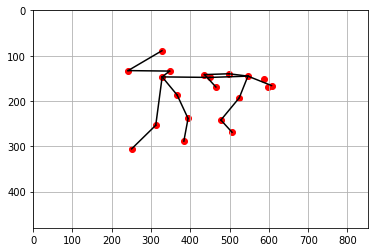

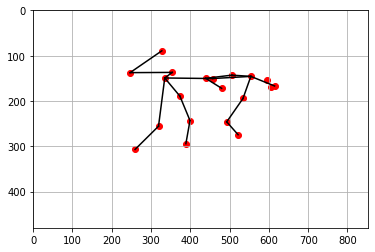

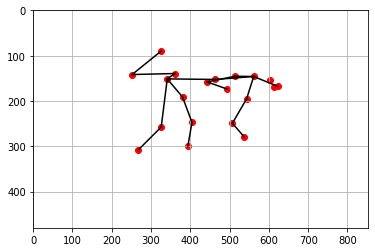

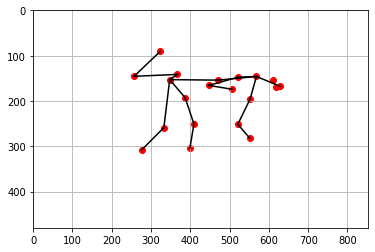

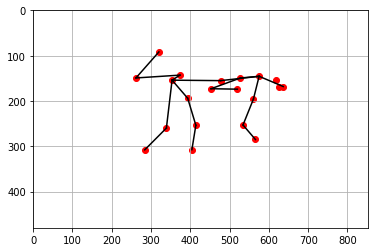

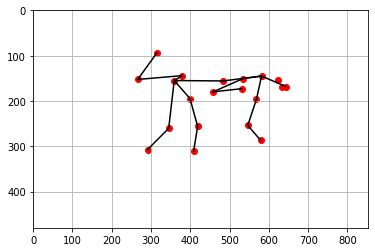

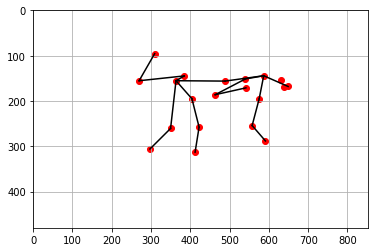

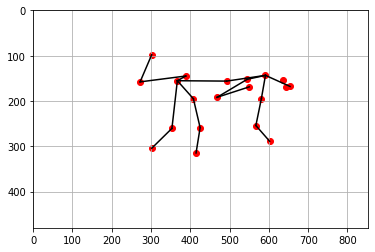

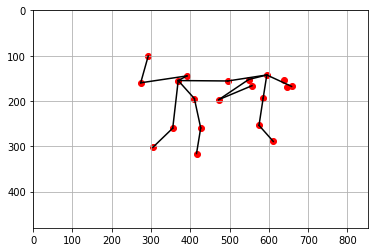

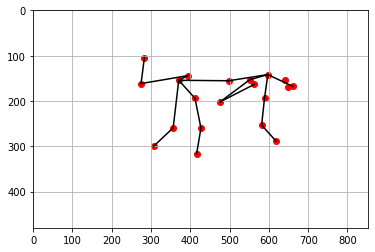

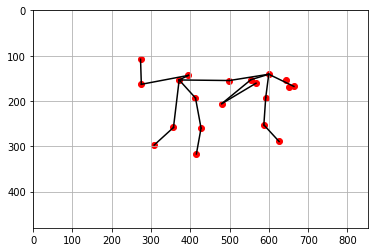

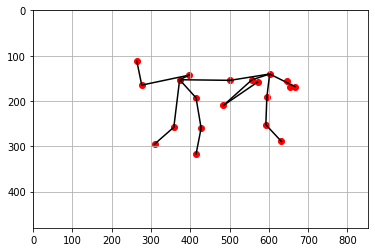

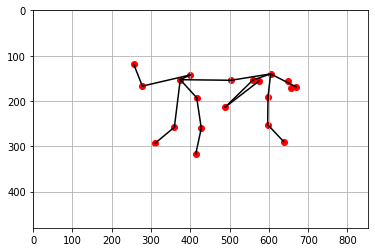

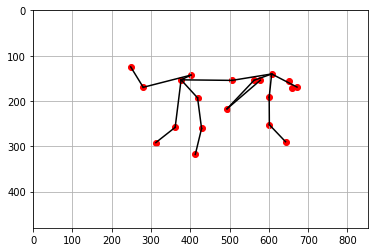

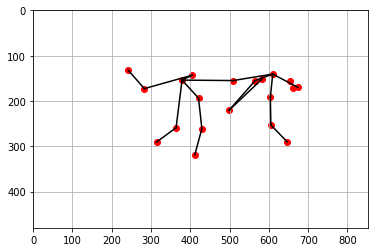

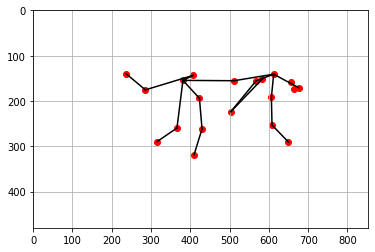

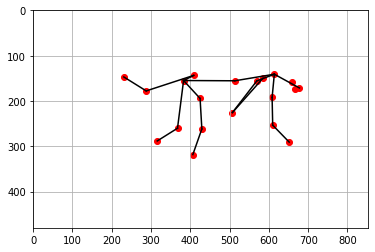

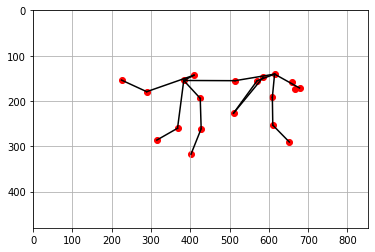

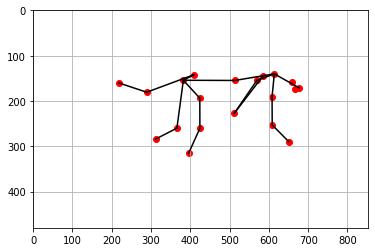

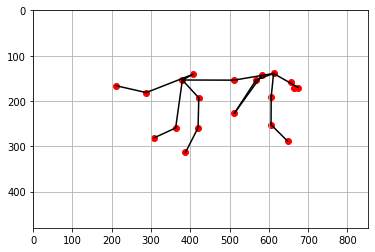

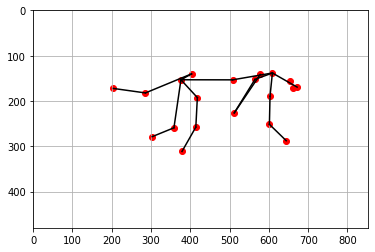

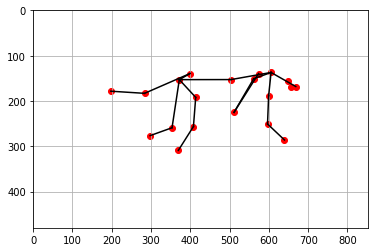

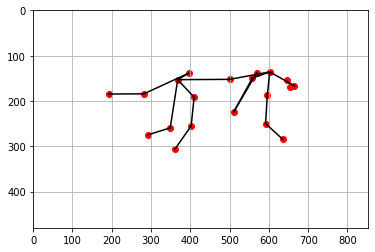

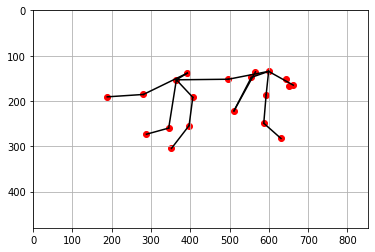

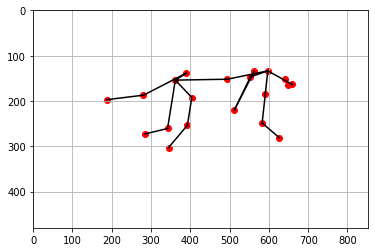

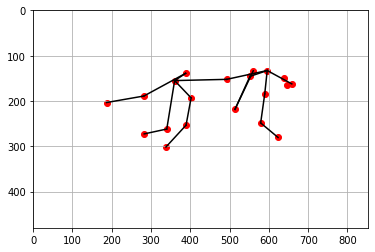

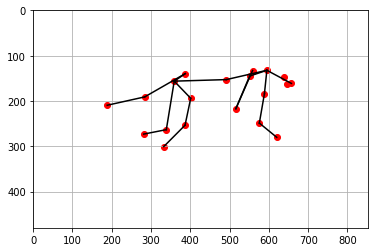

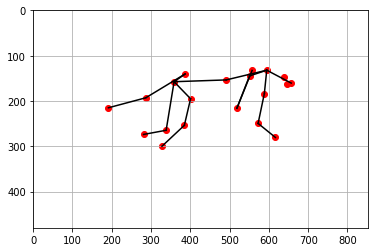

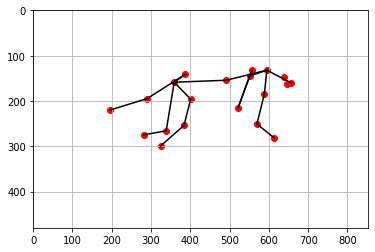

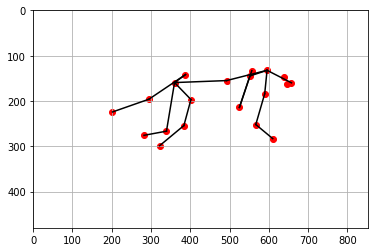

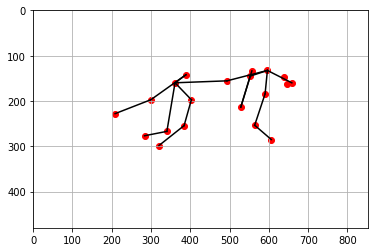

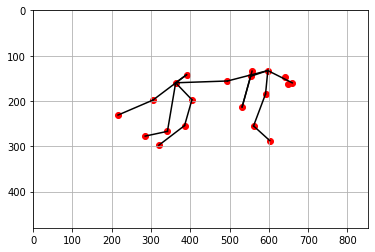

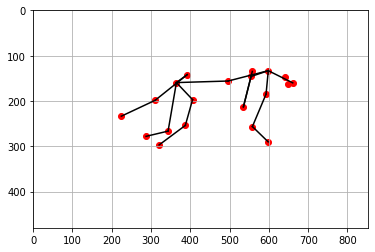

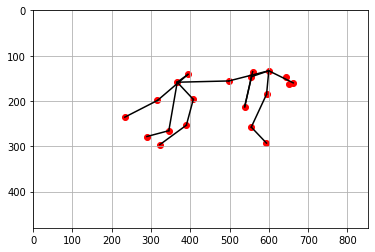

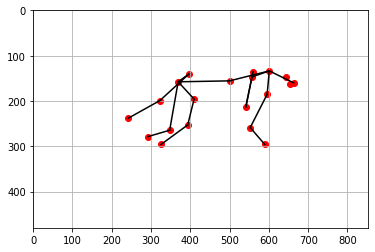

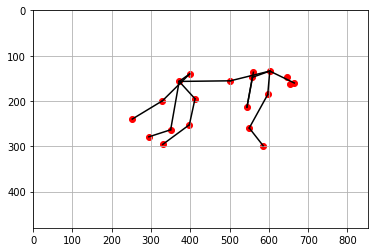

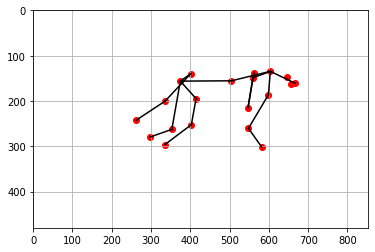

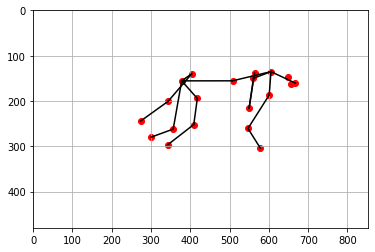

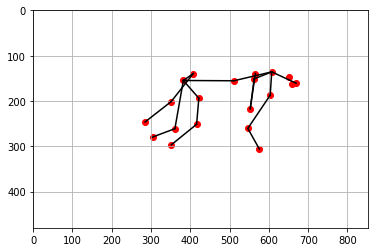

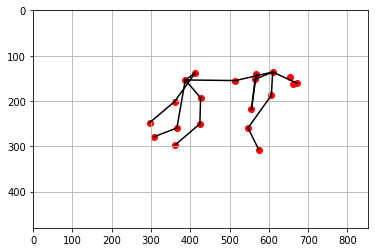

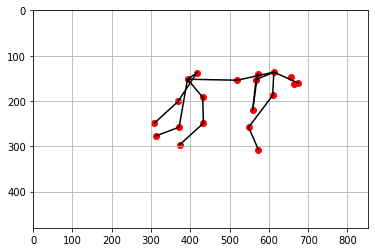

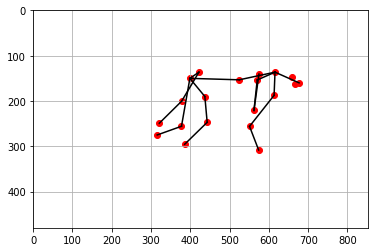

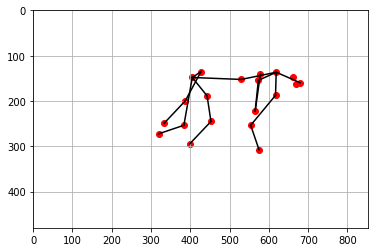

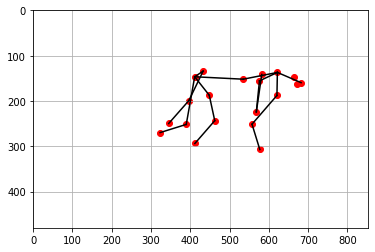

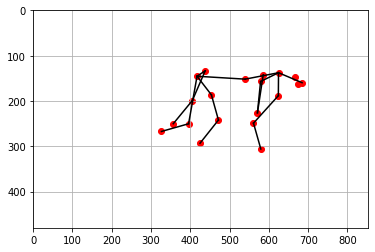

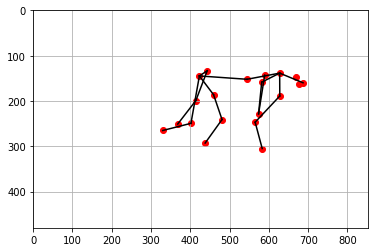

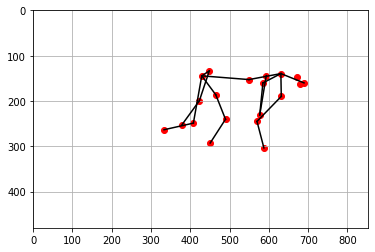

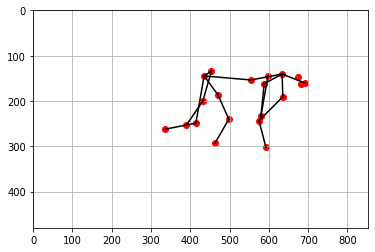

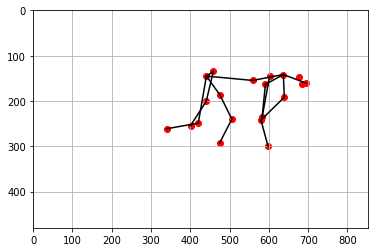

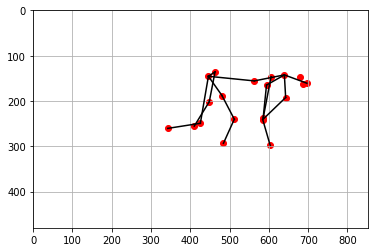

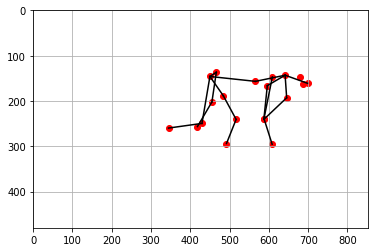

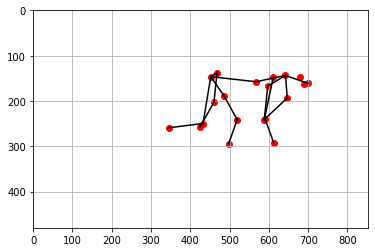

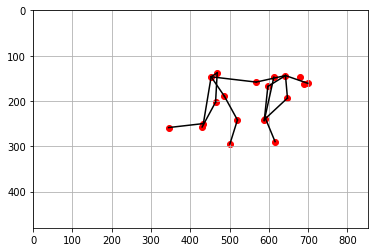

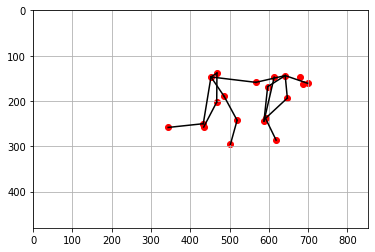

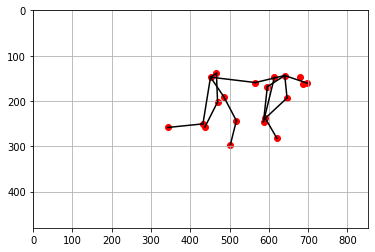

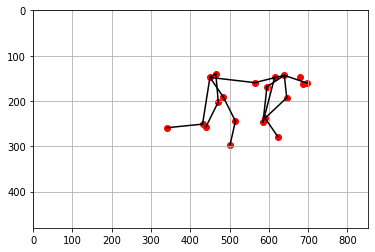

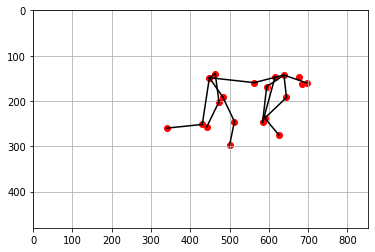

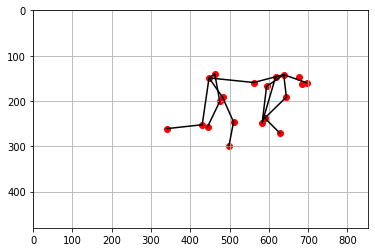

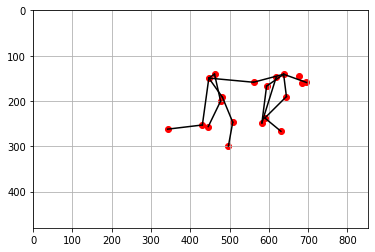

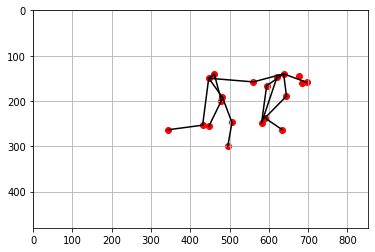

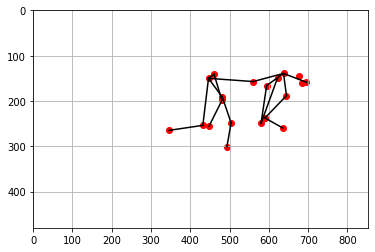

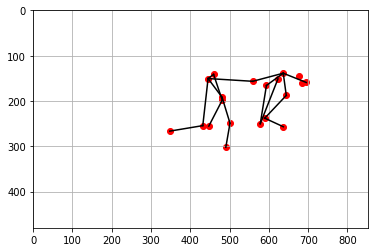

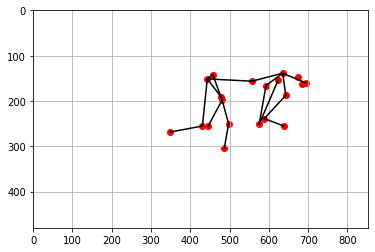

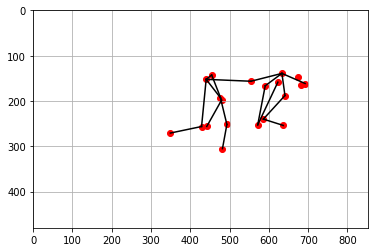

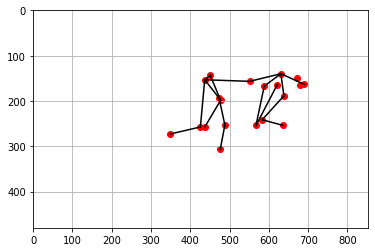

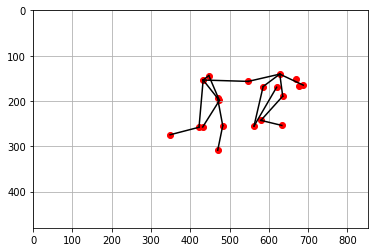

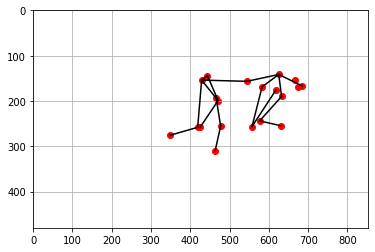

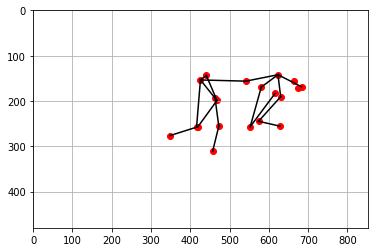

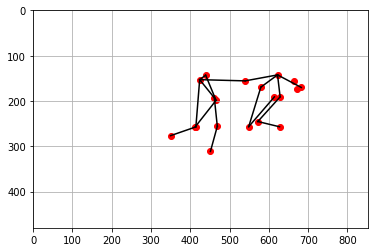

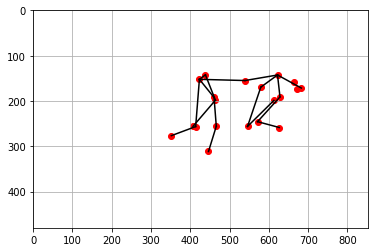

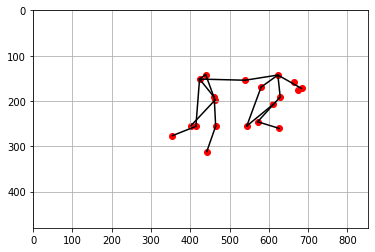

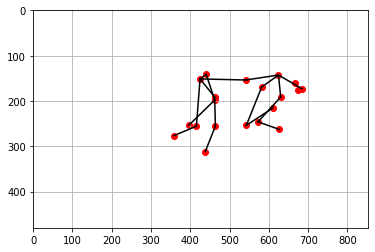

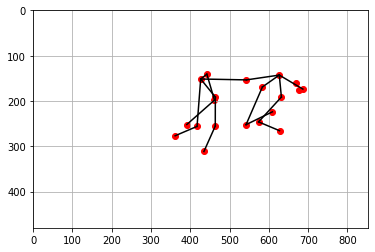

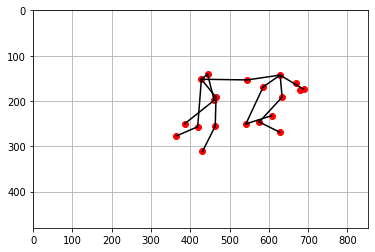

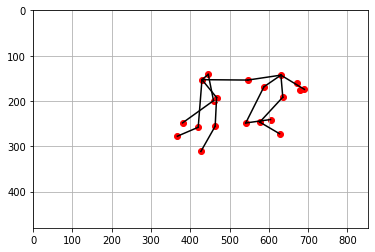

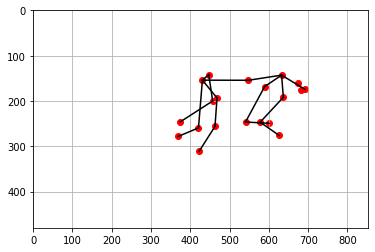

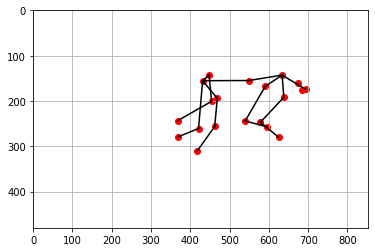

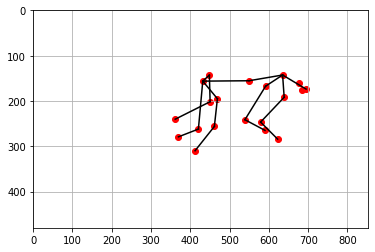

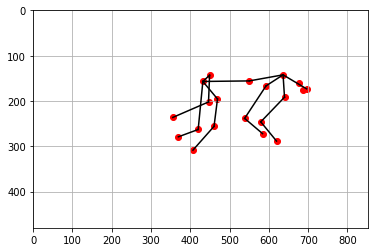

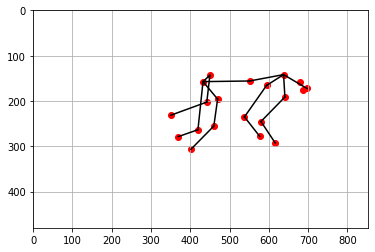

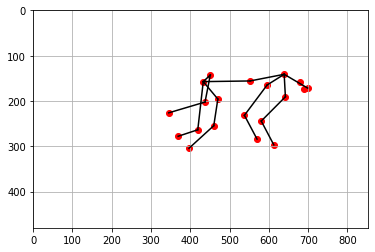

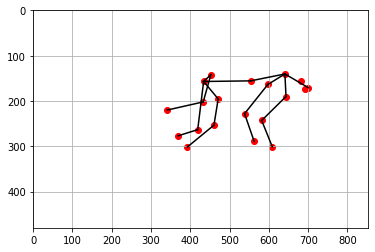

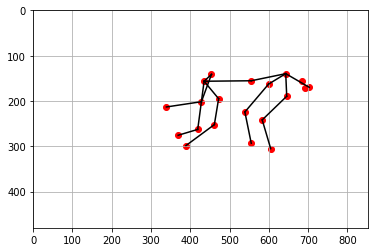

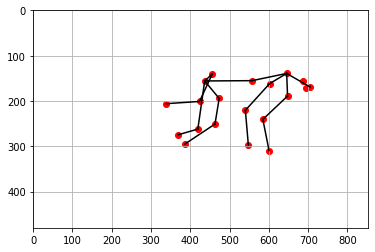

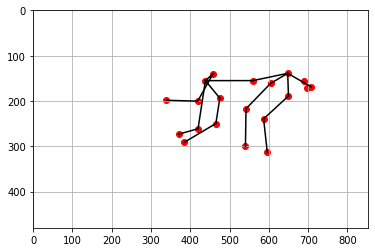

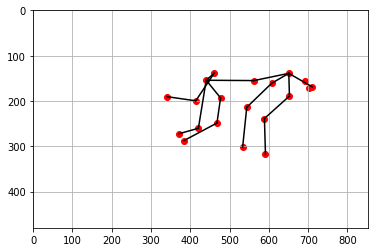

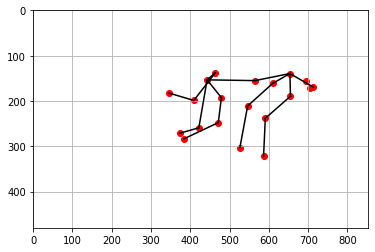

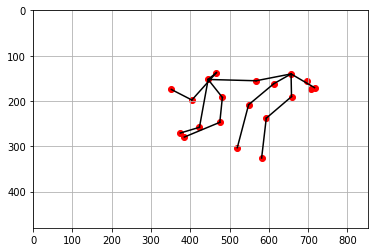

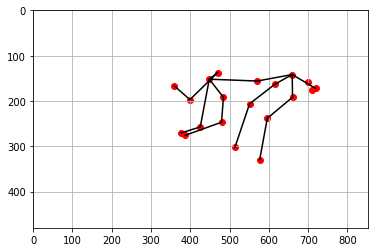

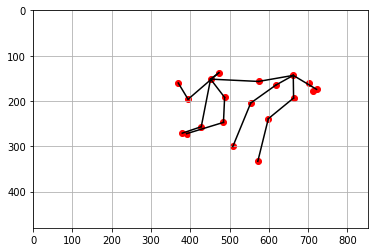

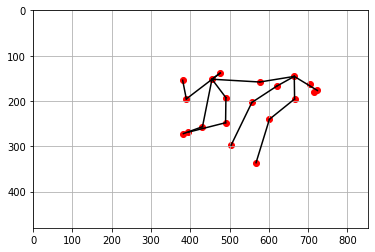

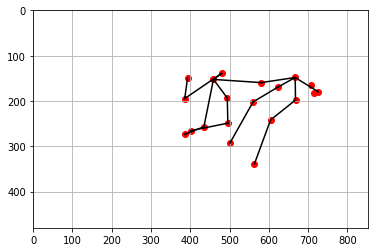

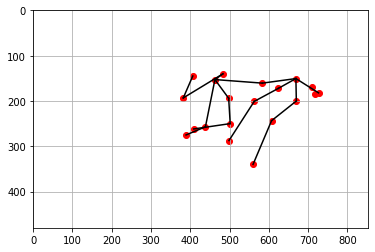

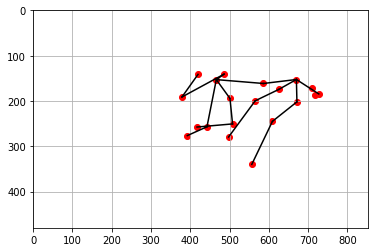

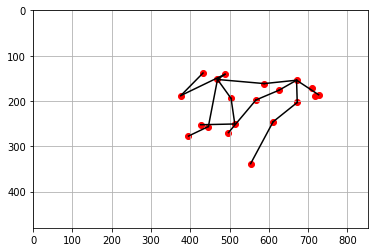

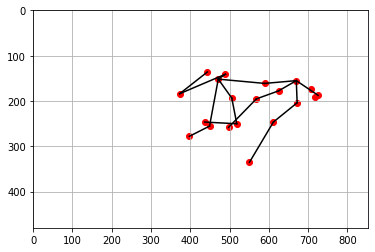

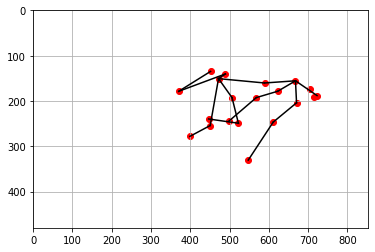

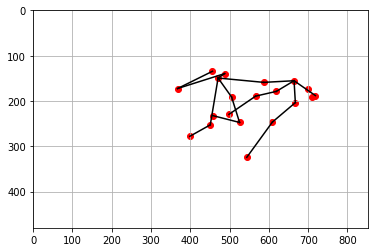

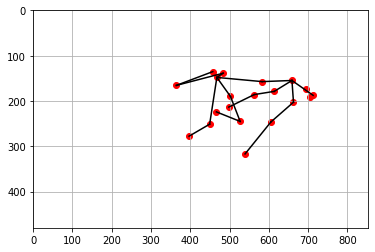

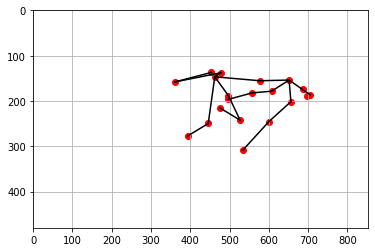

<Figure size 432x288 with 0 Axes>

In [55]:

import matplotlib.pyplot as plt
import analyse as an

#img = plt.imread("C://Users//user-pc//Desktop//misc_wildpose_work//cheetahs//frame1721.jpg")
#fig, ax = plt.subplots()
#ax.imshow(img)

i=0

OUT_DIR = os.path.join(DATA_DIR, 'fte')

data_fpath = os.path.join(OUT_DIR, 'fte.pickle')

data_mat = an.load_pickle(data_fpath)

positions = data_mat["positions"]

print(markers)
links=[['nose', 'neck_base'], ['neck_base', 'spine'], ['spine', 'tail_base'], ['tail_base', 'tail1'], ['tail1', 'tail2'], 
['neck_base', 'l_shoulder'], ['l_shoulder', 'l_front_knee'], ['l_front_knee', 'l_front_ankle'], 
['neck_base', 'r_shoulder'], ['r_shoulder', 'r_front_knee'], ['r_front_knee', 'r_front_ankle'], 
['tail_base', 'l_hip'], ['l_hip', 'l_back_knee'], ['l_back_knee', 'l_back_ankle'], 
['tail_base', 'r_hip'], ['r_hip', 'r_back_knee'], ['r_back_knee', 'r_back_ankle']]


for frame in positions:
    #ax.clear()
    #img = plt.imread("C://Users//user-pc//Desktop//misc_wildpose_work//cheetahs//frame17"+str(i+21)+".jpg")
    fig, ax = plt.subplots()
    ax.grid()
    #ax.imshow(img)
    ax.set_xlim(0,852)
    ax.set_ylim(480,0)
    pose_dict={}
    m=0
    
    for pt in frame:
        #print(pt[0])
        pixs = xyz_to_uv(pt[0], pt[1], pt[2], K)
        pose_dict[markers[m]]=pixs
        #print(pixs)
        ax.scatter(pixs[0], pixs[1], c="red")
        m+=1
    
    for link in links:
        ax.plot([pose_dict[link[0]][0], pose_dict[link[1]][0]],
                     [pose_dict[link[0]][1], pose_dict[link[1]][1]],c="black")
    
    i+=1
    plt.savefig("/Users/user/Desktop/plotted/im"+str(i).zfill(3)+".jpg", dpi=100)
    print("saved "+str(i))


plt.cla()
plt.clf()
        

# Plot the cheetah!

In [41]:
OUT_DIR = os.path.join(DATA_DIR, 'fte')

data_fpath = os.path.join(OUT_DIR, 'fte.pickle')
app.plot_cheetah_reconstruction(data_fpath, reprojections=False, centered=True, dark_mode=True)

RecursionError: maximum recursion depth exceeded while calling a Python object